# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

Study on simple random sinusoidal images vs. real valued bent functions (maximaly non-linear) images

### Simple sinusoidal images:
Generate sinusoidal data with random phase and frequency:

$$Z = \sin(2\pi f_x x + \phi_x) \cos(2\pi f_y y + \phi_y)$$

Where:
- $f_x$ is the frequency multiplier for x
- $f_y$ is the frequency multiplier for y
- $\phi_x$ is the phase shift for x
- $\phi_y$ is the phase shift for y

### Real valued Bent functions:

$$Z = \cos(2\pi(aX + bY)) + \cos(2\pi(cX - dY))$$

Where $a$, $b$, $c$, and $d$ are parameters controlling the function's behavior.



## Imports and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

import scienceplots
plt.style.use(['science','no-latex'])

# Query the current default figure size
current_fig_size = plt.rcParams["figure.figsize"]
print(f"Current default figure size: {current_fig_size}")

# Define a scalar factor
scalar_factor = 1.5

# Multiply the current figure size by the scalar factor
new_fig_size = [size * scalar_factor for size in current_fig_size]

# Set the new default figure size
plt.rcParams["figure.figsize"] = new_fig_size

print(f"New default figure size: {new_fig_size}")
import numpy as np
import torch
import torchinfo
from sklearn import decomposition

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [3]:
import polcanet.polcanet_reports as report
from polcanet import LinearDecoder, PolcaNet
from polcanet.example_aencoders import (
    ConvEncoder,   
    generate_2d_sinusoidal_data,
    generate_bent_images,
)

In [4]:
import utils as ut
import random

random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

exp = ut.ExperimentInfoHandler(
    name="SYNTH_dataset",
    description="POLCA-Net on Synthetic Sinudosial and Bent Images",
    random_seed=random_seed,
)
report.set_save_fig(True)
report.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving Images: {report.get_save_fig()}, saving in path: {report.get_save_path()}")

Saving Images: True, saving in path: /data/deploy/polcanet/examples/notebooks/SYNTH_dataset


## Generate Synthetic Sinudosial and Bent Images

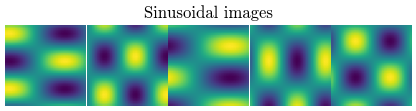

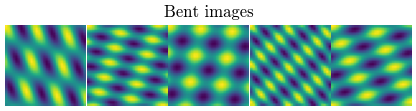

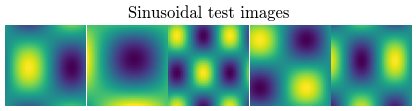

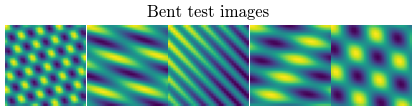

In [5]:
# Parameters
N = 32  # rows
M = 32  # cols
num_samples = 1000

# Generate 2D sinusoidal data
data_sin = generate_2d_sinusoidal_data(N, M, num_samples=num_samples)
data_sin_test = generate_2d_sinusoidal_data(N, M, num_samples=num_samples)

# Generate 2D real bent function images data
data_bent = generate_bent_images(N, M, num_samples=5000)
data_bent_test = generate_bent_images(N, M, num_samples=num_samples)

report.set_fig_prefix("sin_train")
ut.plot_train_images(data_sin, "Sinusoidal images",cmap="viridis", n=5)
report.set_fig_prefix("bent_train")
ut.plot_train_images(data_bent, "Bent images",cmap="viridis", n=5)

report.set_fig_prefix("sin_test")
ut.plot_train_images(data_sin_test, "Sinusoidal test images",cmap="viridis", n=5)
report.set_fig_prefix("bent_test")
ut.plot_train_images(data_bent_test, "Bent test images",cmap="viridis", n=5)

### Perform PCA on datasets

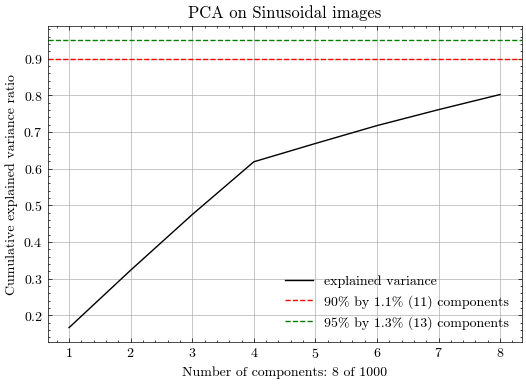

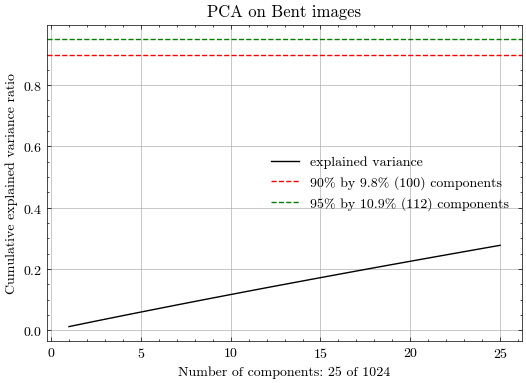

In [6]:
n_components = 8 #int((N*M)//100)
report.set_fig_prefix("sin")
fig, axs = plt.subplots(1,1,sharex=True, sharey=True,layout='constrained')
pca_sin = ut.get_pca(data_sin,ax=axs,title="PCA on Sinusoidal images",n_components=n_components)
plt.show()

n_components =  int((N*M)/40)
report.set_fig_prefix("bent")
fig, axs = plt.subplots(1,1,sharex=True, sharey=True,layout='constrained')
pca_bent = ut.get_pca(data_bent,ax=axs,title="PCA on Bent images",n_components=n_components)
plt.show()

## POLCA-Net

### Train on Sinusoidal Images

In [7]:
from polcanet.example_aencoders import ConvEncoder

ae_input = data_sin
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca_sin.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"


encoder_sin = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder_sin = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=5*256,
    num_layers=5,
    act_fn=act_fn,
    bias = False,
)

model_sin = PolcaNet(
    encoder=encoder_sin,
    decoder=decoder_sin,
    latent_dim=latent_dim,
    alpha=1.0,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=0.0,  # variance reduction loss
    device="cuda",
    center=True,
    factor_scale=True,
   
)
print(model_sin)
summary = torchinfo.summary(
    model_sin,
    (1, *input_dim),
    dtypes=[torch.float],
    verbose=1,    
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
report.save_text(str(model_sin),"model_sin.txt")
report.save_text(str(summary),"model_sin_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): SiLU()
        (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (5): SiLU()
        (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (7): SiLU()
        (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (9): SiLU()
        (10): Flatten(start_dim=1, end_dim=-1)
        (11): Linear(in_features=256, out_features=32, bias=True)
        (12): SiLU()
        (13): Linear(in_features=32, out_features=8, bias=True)
      )
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=1280, bias=False)
      (1): SiLU()
      (2): Linear(in_features=1280, out_features=1280,

In [8]:
model_sin.to("cuda")
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=10000, report_freq=20, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 10000
Total Loss: 0.006632
Reconstruction Loss: 0.002004
Orthogonality Loss: 0.002216
Center of Mass Loss: 0.00133
Variance Distribution Loss: 0


0.006631838856264949

In [9]:
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=10000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 10000
Total Loss: 0.002042
Reconstruction Loss: 0.0003207
Orthogonality Loss: 0.001037
Center of Mass Loss: 0.0003509
Variance Distribution Loss: 0


0.002042225212790072

In [10]:
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=10000, report_freq=20, lr=1e-5)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 10000
Total Loss: 0.001296
Reconstruction Loss: 8.427e-05
Orthogonality Loss: 0.0008185
Center of Mass Loss: 0.0001905
Variance Distribution Loss: 0


0.001295512425713241

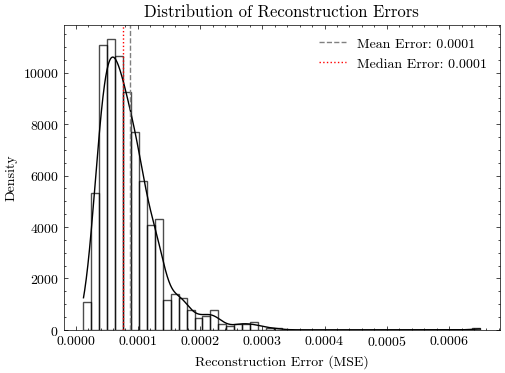

Mean Reconstruction Error: 0.0001
Median Reconstruction Error: 0.0001
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0006


In [11]:
report.set_fig_prefix("sin_train")
report.analyze_reconstruction_error(model_sin, data_sin, n_samples=10000)

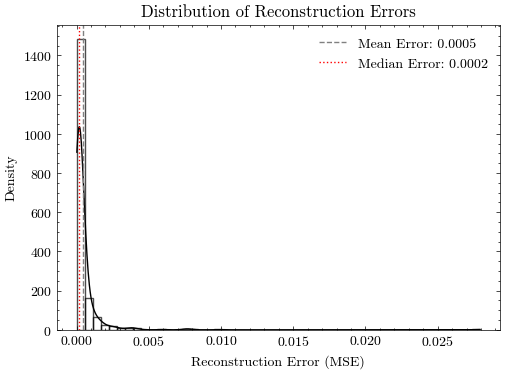

Mean Reconstruction Error: 0.0005
Median Reconstruction Error: 0.0002
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0279


In [12]:
report.set_fig_prefix("sin_test")
report.analyze_reconstruction_error(model_sin, data_sin_test, n_samples=10000)

In [13]:
latents, reconstructed = model_sin.predict(data_sin)
data_sin.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 8))

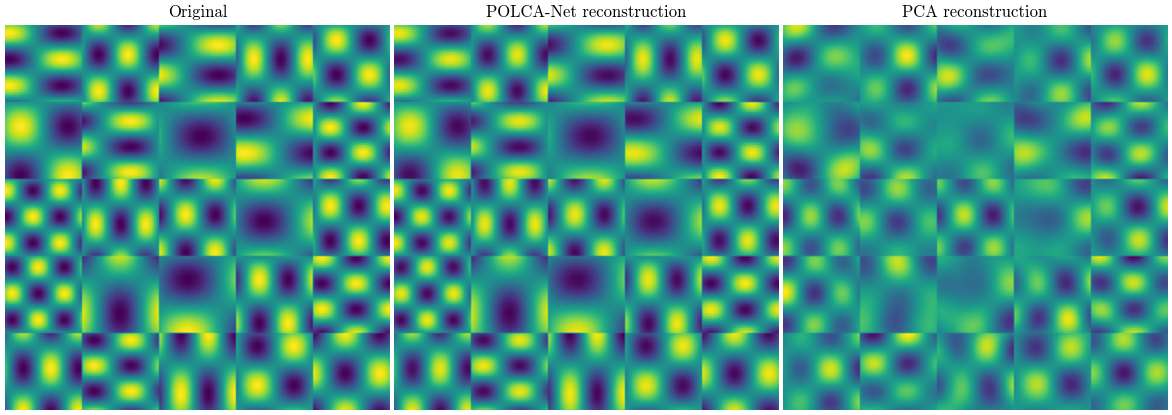

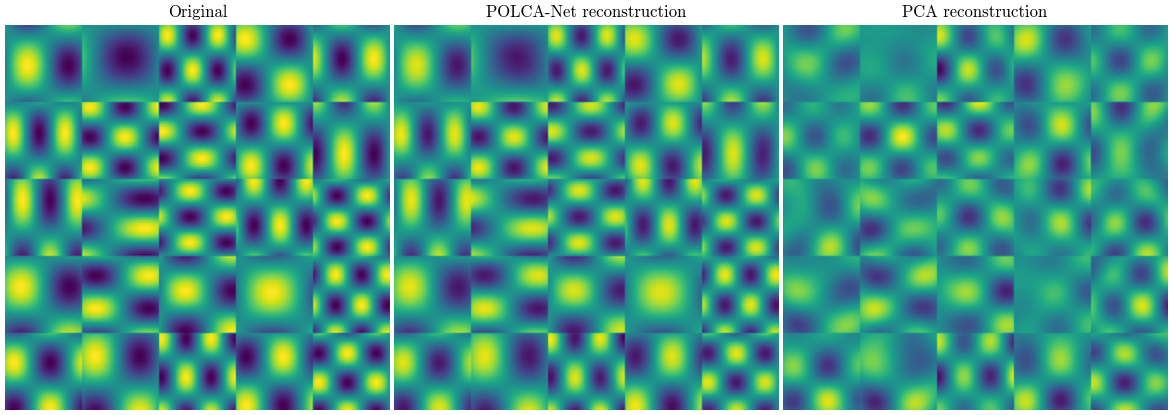

In [14]:
report.set_fig_prefix("sin_train")
images = data_sin[0:25]
ut.plot_reconstruction_comparison(model_sin,pca_sin,images,cmap="viridis",nrow=5)
report.set_fig_prefix("sin_test")
images = data_sin_test[0:25]
ut.plot_reconstruction_comparison(model_sin,pca_sin,images,cmap="viridis",nrow=5)


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0005
    - Max cosine similarity: 0.0071
    - Min cosine similarity: -0.0202
    


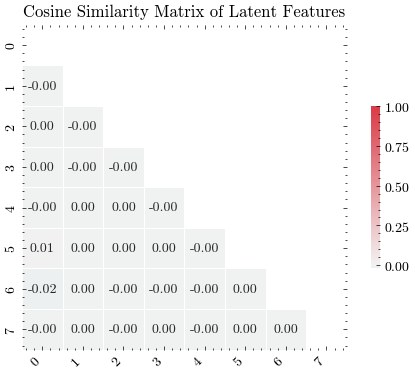

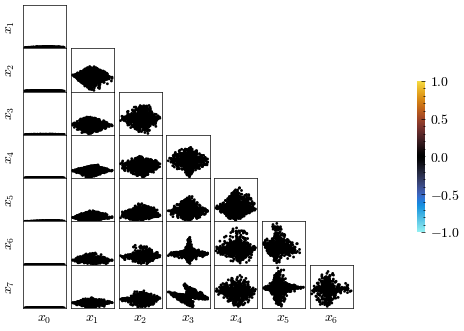


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0069
    - Max cosine similarity: 0.0706
    - Min cosine similarity: -0.0966
    


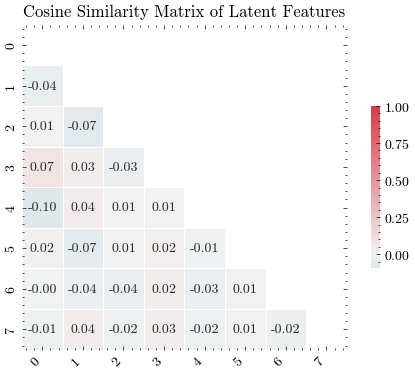

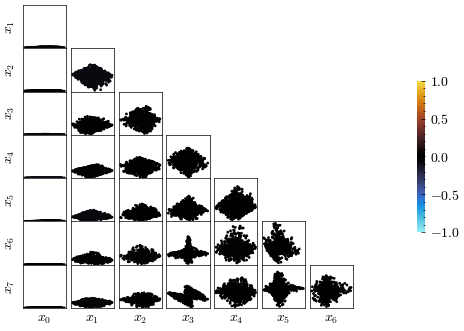

In [15]:
report.set_fig_prefix("sin_train")
report.orthogonality_test_analysis(model_sin, data_sin)
report.set_fig_prefix("sin_test")
report.orthogonality_test_analysis(model_sin, data_sin_test)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.0037
    - Variance fit to exponential distribution (sum of squared differences):
     0.1958
    


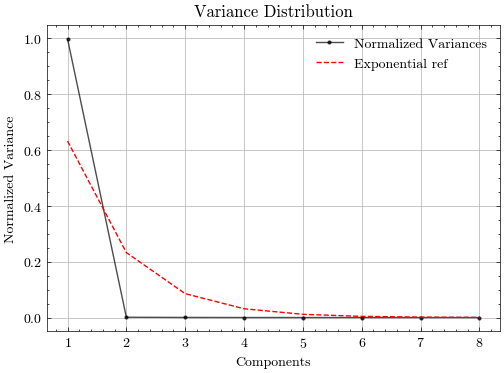

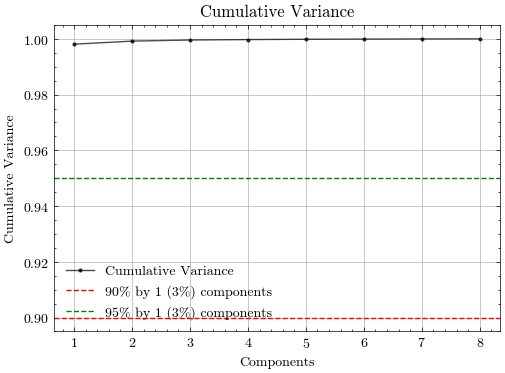

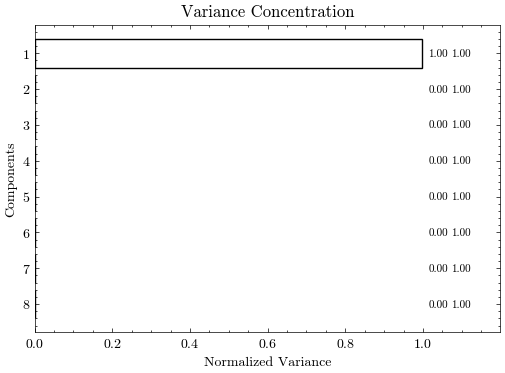


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.0038
    - Variance fit to exponential distribution (sum of squared differences):
     0.1957
    


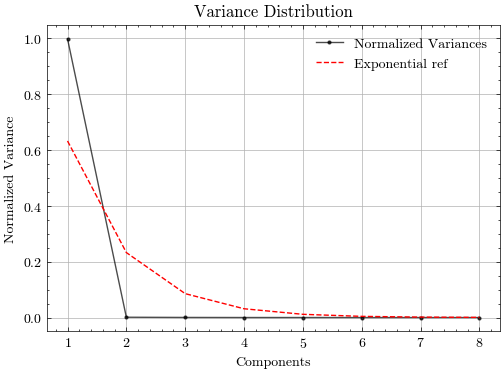

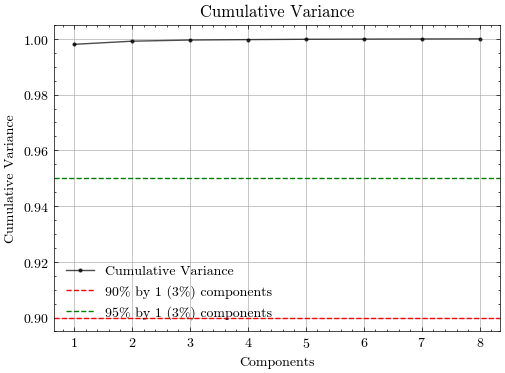

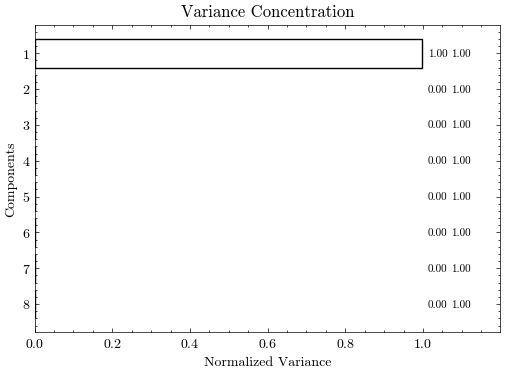

In [16]:
report.set_fig_prefix("sin_train")
report.variance_test_analysis(model_sin, data_sin)
report.set_fig_prefix("sin_test")
report.variance_test_analysis(model_sin, data_sin_test)

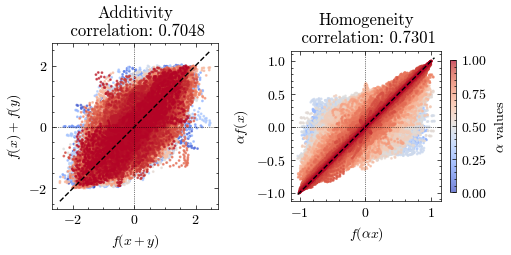

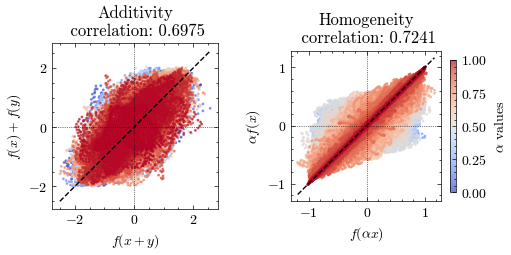

In [17]:
report.set_fig_prefix("sin_train")
report.linearity_tests_analysis(model_sin, data_sin,alpha_min=0,num_samples=200)
report.set_fig_prefix("sin_test")
report.linearity_tests_analysis(model_sin, data_sin_test,alpha_min=0,num_samples=200)

### Train on Bent Images

In [18]:
from polcanet import PolcaNet
from polcanet.polcanet_utils import EncoderWrapper
from polcanet.example_aencoders import DenseEncoder
ae_input = data_bent
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca_bent.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_bent = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder_bent = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=5 * 256,
    num_layers=5,
    act_fn=act_fn,
    bias= False
)

model_bent = PolcaNet(
    encoder=encoder_bent,
    decoder=decoder_bent,
    latent_dim=latent_dim,
    alpha=1.0,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=0.0,  # variance reduction loss
    device="cuda",
    center=True,
    factor_scale=True,
  
)
print(model_bent)
summary = torchinfo.summary(
    model_bent,
    (1, *input_dim),
    dtypes=[torch.float],
    verbose=1,    
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
report.save_text(str(model_bent),"model_bent.txt")
report.save_text(str(summary),"model_bent_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): SiLU()
        (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (5): SiLU()
        (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (7): SiLU()
        (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (9): SiLU()
        (10): Flatten(start_dim=1, end_dim=-1)
        (11): Linear(in_features=256, out_features=100, bias=True)
        (12): SiLU()
        (13): Linear(in_features=100, out_features=25, bias=True)
      )
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=25, out_features=1280, bias=False)
      (1): SiLU()
      (2): Linear(in_features=1280, out_features=1

In [19]:
model_bent.to("cuda")
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.004263
Reconstruction Loss: 0.0006185
Orthogonality Loss: 0.002132
Center of Mass Loss: 0.0007748
Variance Distribution Loss: 0


0.004262705845758319

In [20]:
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=10000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 10000
Total Loss: 0.001741
Reconstruction Loss: 0.0001203
Orthogonality Loss: 0.00115
Center of Mass Loss: 0.0002358
Variance Distribution Loss: 0


0.0017405109480023383

In [21]:
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=10000, report_freq=20, lr=1e-5)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 10000
Total Loss: 0.001311
Reconstruction Loss: 5.072e-05
Orthogonality Loss: 0.001022
Center of Mass Loss: 0.0001173
Variance Distribution Loss: 0


0.0013106727390550077

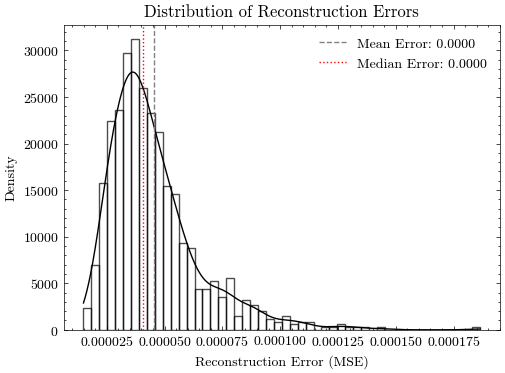

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0002


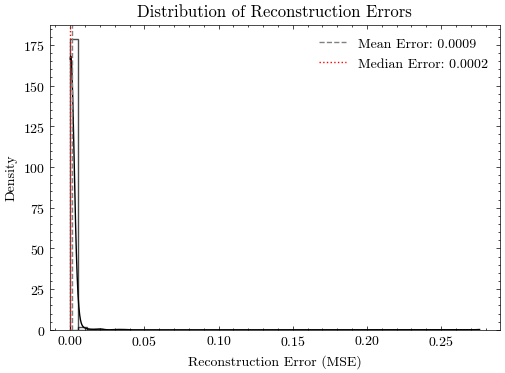

Mean Reconstruction Error: 0.0009
Median Reconstruction Error: 0.0002
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.2759


In [22]:
report.set_fig_prefix("bent_train")
report.analyze_reconstruction_error(model_bent, data_bent, n_samples=1000)
report.set_fig_prefix("bent_test")
report.analyze_reconstruction_error(model_bent, data_bent_test, n_samples=1000)

In [23]:
latents, reconstructed = model_bent.predict(data_bent)
data_bent.shape, reconstructed.shape, latents.shape

((5000, 32, 32), (5000, 32, 32), (5000, 25))

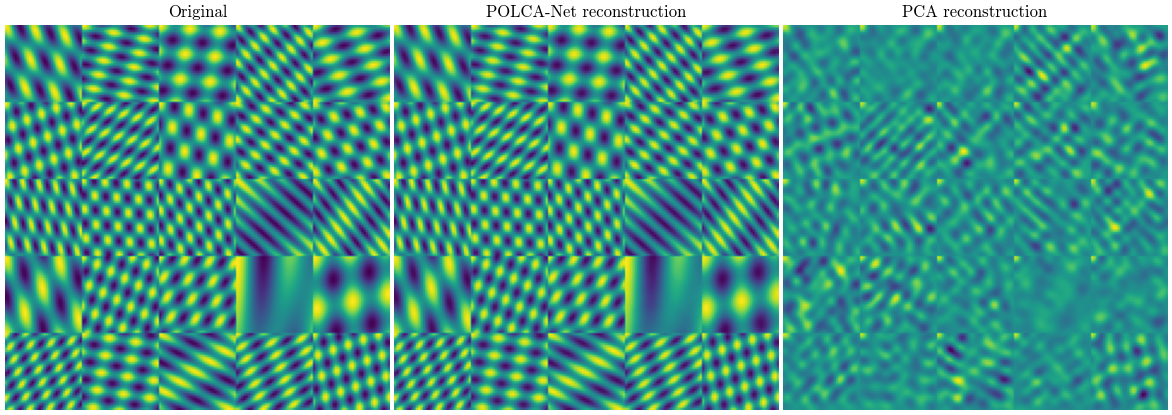

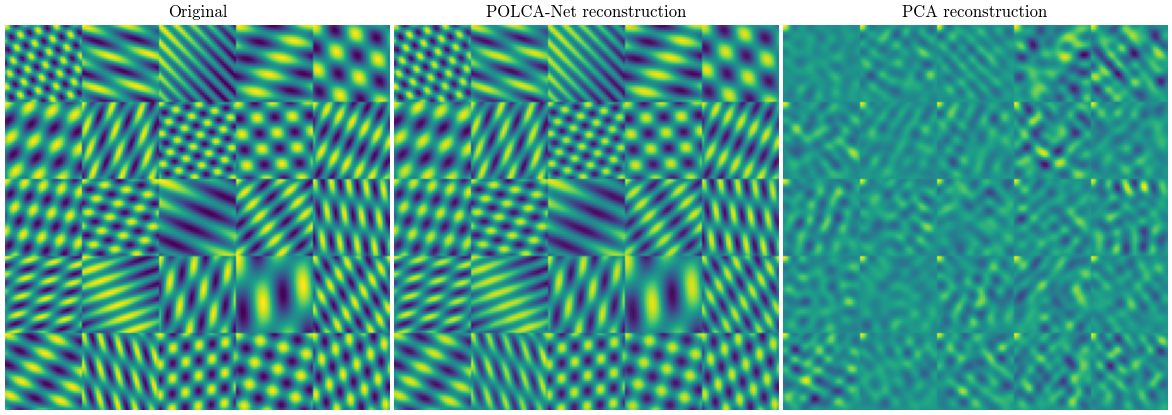

In [24]:
report.set_fig_prefix("sin_train")
images = data_bent[0:25]
ut.plot_reconstruction_comparison(model_bent,pca_bent,images,cmap="viridis",nrow=5)
report.set_fig_prefix("sin_test")
images = data_bent_test[0:25]
ut.plot_reconstruction_comparison(model_bent,pca_bent,images,cmap="viridis",nrow=5)


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0014
    - Max cosine similarity: 0.0677
    - Min cosine similarity: -0.0891
    


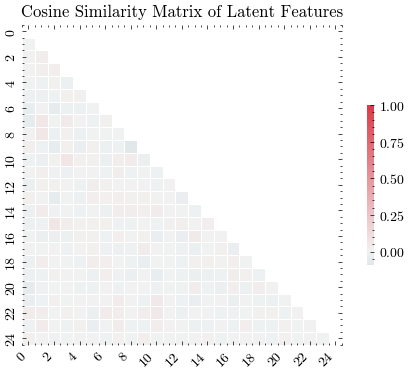

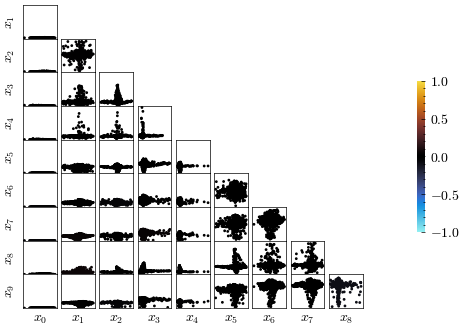


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0035
    - Max cosine similarity: 0.0796
    - Min cosine similarity: -0.0821
    


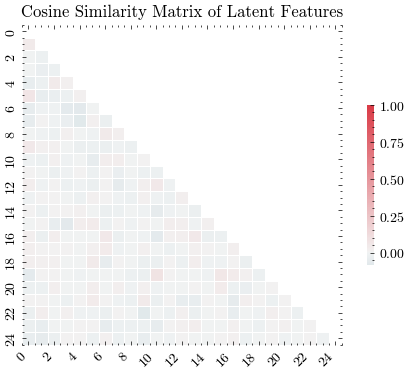

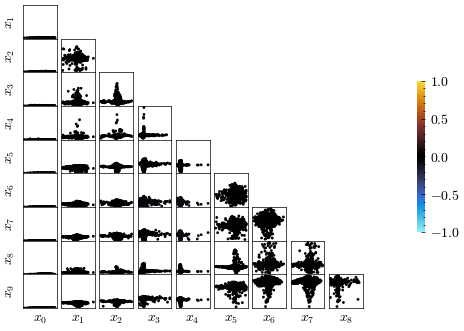

In [25]:
report.set_fig_prefix("bent_train")
report.orthogonality_test_analysis(model_bent, data_bent)
report.set_fig_prefix("bent_test")
report.orthogonality_test_analysis(model_bent, data_bent_test)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.0082
    - Variance fit to exponential distribution (sum of squared differences):
     0.1952
    


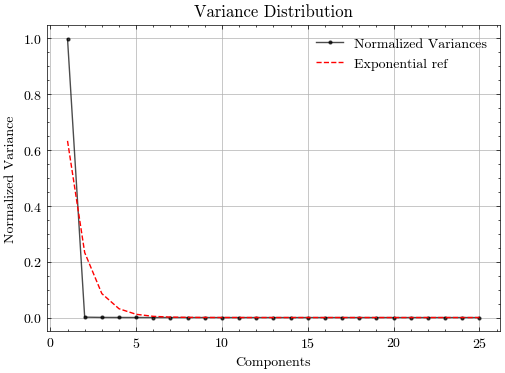

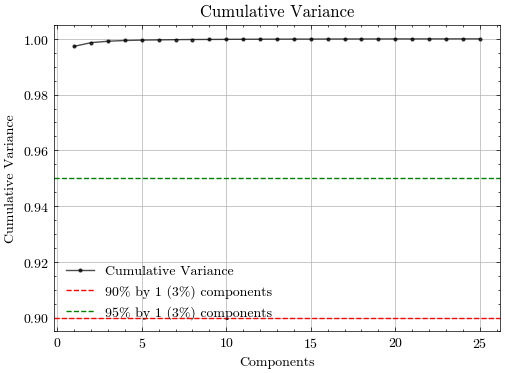

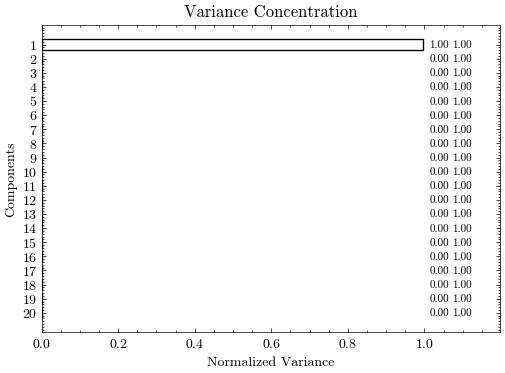


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.0084
    - Variance fit to exponential distribution (sum of squared differences):
     0.1950
    


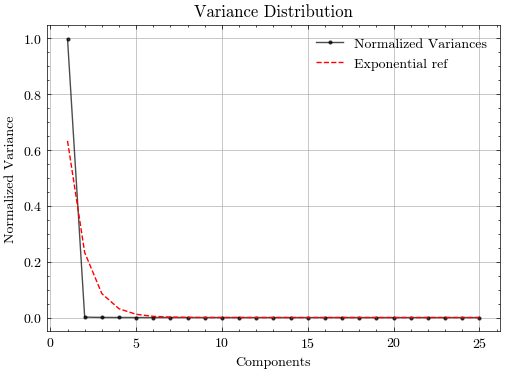

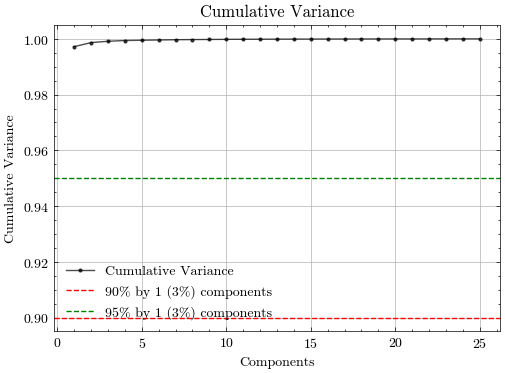

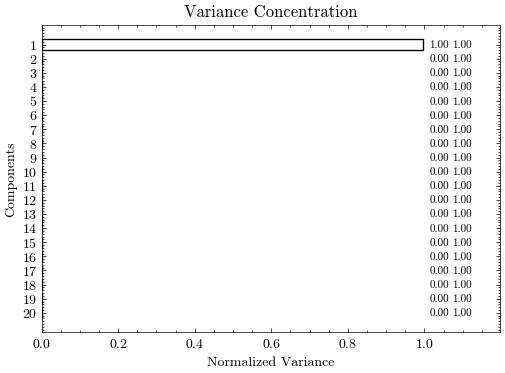

In [26]:
report.set_fig_prefix("bent_train")
report.variance_test_analysis(model_bent, data_bent)
report.set_fig_prefix("bent_test")
report.variance_test_analysis(model_bent, data_bent_test)

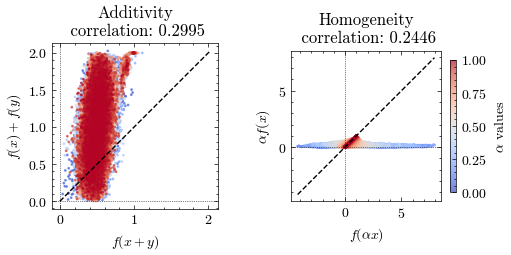

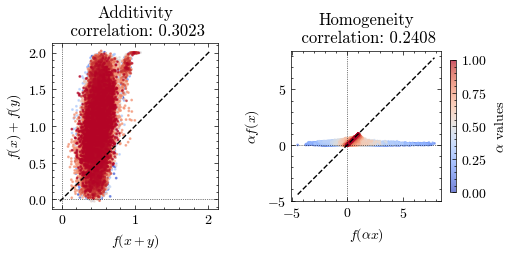

In [27]:
report.set_fig_prefix("bent_train")
report.linearity_tests_analysis(model_bent, data_bent,alpha_min=0,num_samples=200)
report.set_fig_prefix("bent_test")
report.linearity_tests_analysis(model_bent, data_bent_test,alpha_min=0,num_samples=200)

## Test Overall

In [28]:
experiment_data = {
    "Sinudoidal": (
        data_sin,
        model_sin,
        pca_sin,
    ),
    "Bent": (
        data_bent,
        model_bent,
        pca_bent,
    ),
}
_ = ut.image_metrics_table(experiment_data)

Normalized Mean Squared Error  Peak Signal-to-Noise Ratio  \
Method                                                                        
POLCA Sinudoidal                         0.0004                     89.3427   
PCA Sinudoidal                           0.2061                     62.9266   
POLCA Bent                               0.0001                     91.8511   
PCA Bent                                 0.1444                     61.6597   

                  Structural Similarity Index  
Method                                         
POLCA Sinudoidal                       1.0000  
PCA Sinudoidal                         0.9945  
POLCA Bent                             1.0000  
PCA Bent                               0.9984